In [23]:
import os
import sys
import ephem
import desimodel
import pylab as pl
import numpy as np 

sys.path.insert(0, '/global/homes/m/mjwilson/desi/BGS/bgs-cmxsv/surveysim/py/')
sys.path.insert(0, '/global/homes/m/mjwilson/desi/BGS/bgs-cmxsv/desisurvey/py/')

import desisurvey
import surveysim.stats

from astropy.io import fits
from astropy.time import Time
from astropy.table import Table

# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
_dir = '/global/cscratch1/sd/chahah/desisurvey_output'

In [3]:
surveysim.__path__

['/global/homes/m/mjwilson/desi/BGS/bgs-cmxsv/surveysim/py/surveysim']

In [4]:
desisurvey.__path__

['/global/homes/m/mjwilson/desi/BGS/bgs-cmxsv/desisurvey/py/desisurvey']

In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
config = desisurvey.config.Configuration()

lat=config.location.latitude(),
lon=config.location.longitude(),
height=config.location.elevation()

lon, lat, height

((<Quantity -111.59933611 deg>,),
 (<Quantity 31.96397222 deg>,),
 <Quantity 2120. m>)

In [16]:
mayall = ephem.Observer()
mayall.lat = '-111.599'
mayall.lon = '31.963'
mayall.date = Time(exps['MJD'][0], format='mjd').iso

In [17]:
moon = ephem.Moon()
moon.compute(mayall)

moon.ra, moon.dec

(5.560604855755167, -0.32421733764830557)

In [106]:
def surveysim_summary(texp, footprint, version=8, deepfirst=False, twilight=False):
    _file = ('%is_bgs%i_skybranch_v%i%s.brightsky%s%s' % 
             (texp, footprint, version, ['', '.twilight'][twilight], ['', '.deepfirst'][deepfirst], ['.bgs%i' % footprint, ''][footprint == 14000]))

    fstats = os.path.join(_dir, 'stats_%s.fits' % _file)
    stats = surveysim.stats.SurveyStatistics(restore=fstats, bgs_footprint=[footprint, None][footprint == 14000])

    tiles_file = '/global/cscratch1/sd/chahah/desisurvey_output/desi-tiles.ecsv'
    tiles      = Table.read(tiles_file)

    assert np.all(stats.tiles.tileID == tiles['TILEID'].data)
    
    fexps = os.path.join(_dir, 'exposures_%s.fits' % _file)
    exps = fits.getdata(fexps, 'exposures')
    
    stats.summarize()
    
    actual = np.cumsum(stats._data['completed'], axis=0)

    # Map to absolute pass number for third bright pass, e.g. returns pass 7. 
    third_pass = stats.tiles.program_passes['BRIGHT'][-1]
    
    # This is really ntile in the third pass. 
    npass = stats.tiles.pass_ntiles[third_pass]
    
    # Indices into pass array for non-consecutive / non-dense pass numbers.  
    passidx = stats.tiles.pass_index[third_pass]
    
    '''
    bgs_complete = (actual[:,passidx] / npass) == 1.

    dt = 1 + np.arange(len(stats._data))
    print('BGS finishes 3rd passs on day %i of %i' % (dt[bgs_complete].min(), dt[-1]))
    print('  %.3f percent margin' % (100.*(dt[-1] - dt[bgs_complete].min())/dt[-1]))
    '''
    
    # ntile length array of whether in BGS. 
    _pass = np.isin(stats.tiles.passnum, stats.tiles.program_passes['BRIGHT'])

    # BGS tileids.
    tileid_pass = stats.tiles.tileID[_pass]
    
    '''
    Returns:
        intersect1dndarray
            Sorted 1D array of common and unique elements.

        comm1ndarray
            The indices of the first occurrences of the common values in ar1. Only provided if return_indices is True.

        comm2ndarray
            The indices of the first occurrences of the common values in ar2. Only provided if return_indices is True.
    
    '''
    
    _, m0, m1 = np.intersect1d(exps['TILEID'], tileid_pass, return_indices=True)
    
    t_exps = Time(exps['MJD'], format='mjd')

    fig = plt.figure(figsize=(16, 8))
    
    # Will assumes consecutive pass. 
    min_pass = stats.tiles.program_passes['BRIGHT'][0]
    
    mjds = np.linspace(exps['MJD'].min(), exps['MJD'].min() + 365, 250)
    moon_radec = []
    
    for mjd in mjds:
        mayall.date = Time(mjd, format='mjd').iso  
    
        moon.compute(mayall)

        # Time(mjd, format='mjd').iso
        moon_radec.append([mjd, np.degrees(moon.ra), np.degrees(moon.dec)])           
    
    moon_radec = np.array(moon_radec)
    
    for year in range(5): 
        # inyear = (t_exps[m0].decimalyear >= t_exps.decimalyear.min() + year) & (t_exps[m0].decimalyear < (t_exps.decimalyear.min() + year + 1))

        bynowyear = (t_exps[m0].decimalyear >= t_exps.decimalyear.min()) & (t_exps[m0].decimalyear < (t_exps.decimalyear.min() + year + 1))
        
        sub = fig.add_subplot(2,3,year+1)

        # sub.scatter(((stats.tiles.tileRA[_pass][m1][inyear] - 80) % 360) + 80, stats.tiles.tileDEC[_pass][m1][inyear], s=5, c='k')

        sub.plot(((moon_radec[:,1] - 80) % 360) + 80., moon_radec[:,2], c='k', lw=0.0, marker=',')
        
        # _pass:  in BRIGHT 
        toplot = Table(tiles[_pass][m1][bynowyear], copy=True)
        
        toplot_passes = np.unique(toplot['PASS'].data)[::-1]

        # print()
        # print()
        
        for i, pp in enumerate(toplot_passes):
            in_pass = toplot['PASS'].data == pp 
                    
            sub.scatter(((toplot['RA'].data[in_pass] - 80) % 360) + 80, toplot['DEC'].data[in_pass], s=5, c=colors[pp - min_pass], label='Pass {:d}'.format(pp - min_pass))

            plotted_centerids = np.unique(toplot['CENTERID'].data[in_pass])

            to_remove = np.isin(toplot['CENTERID'].data, plotted_centerids)

            # print(pp)
            # print(len(toplot))
            
            toplot = toplot[~to_remove]
     
            # print(len(toplot))
        
        sub.set_xlim(440, 80)
        sub.set_ylim(-55., 90.)
        sub.legend(frameon=False, loc=3)
        sub.text(0.25, 0.95, 'Year %i' % (year+1), transform=sub.transAxes, ha='right', va='top', fontsize=20)

        if year not in [0, 3]: 
            sub.set_yticklabels([])
        if year < 2: 
            sub.set_xticklabels([])
            
    bkgd = fig.add_subplot(111, frameon=False)
    bkgd.set_xlabel(r'RA', labelpad=10, fontsize=25) 
    bkgd.set_ylabel(r'Dec', labelpad=10, fontsize=25) 
    bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    return fig, exps, stats, moon_radec

#     fig, sub = stats.plot()
    
#     # get BGS tiles
#     _pass = np.zeros(len(stats.tiles.passnum)).astype(bool)
#     for i in range(3):
#         _pass = _pass | (stats.tiles.passnum == stats.tiles.program_passes['BRIGHT'][i-3])

#     tileid_pass = stats.tiles.tileID[_pass]
#     _, m0, m1 = np.intersect1d(exps['TILEID'], tileid_pass, return_indices=True)
    
#     fig = plt.figure(figsize=(10,5))
#     sub = fig.add_subplot(111)

#     sub.scatter(((stats.tiles.tileRA[_pass] - 80) % 360) + 80, stats.tiles.tileDEC[_pass], s=5, c='k')
#     sub.set_xlim(80, 440)
#     sub.set_ylabel('Dec', fontsize=25)
#     sub.set_ylim(-25., 90.)
#     sub.set_xlabel('RA', fontsize=25)

#     fig = plt.figure(figsize=(6,6))
#     sub = fig.add_subplot(111)
#     sub.hist(exps['SKY'][m0], range=(0., 5), bins=50)
#     #sub.plot([2.5, 2.5], [0., 750], c='k', ls='--')
#     sub.text(0.95, 0.95, 'median=%.2f' %np.median(exps['SKY'][m0]), transform=sub.transAxes, ha='right', va='top', fontsize=20)
#     sub.set_xlabel('sky brightness exposure factor', fontsize=25)
#     sub.set_xlim(0., 5)

(15984,)
INFO:stats.py:79:__init__: Restored stats from /global/cscratch1/sd/chahah/desisurvey_output/stats_300s_bgs14000_skybranch_v8.brightsky.fits
INFO:stats.py:81:__init__:   Comment: "".
Scheduled 10545.349 hr Open 74.915% Live 74.277%
PROG PASS    TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
DARK   1 2011/1998  5996  2952  14  3044  11 1856.1s 176.5s  91.0s
DARK   2 2007/1998  6146  3028  16  3118   3 1948.3s 181.5s  93.3s
DARK   3 2010/1998  5959  2888  15  3071   3 1966.8s 172.9s  91.7s
DARK   4 2005/1998  6242  3222  14  3020   4 1836.1s 193.3s  90.4s
DARK     8033/7992 24343 12090  59 12253  21 1901.8s 181.1s  91.6s 2294.1s 114.2s
----------------------------------------------------------------------------------
GRAY   0 2010/1998  6067  3040  19  3027   7 1863.8s 182.0s  90.5s
GRAY     2010/1998  6067  3040  19  3027   7 1863.8s 182.0s  90.5s 2322.9s 208.4s
----------------------------------------------------------------------------------
BRIGHT 5 200

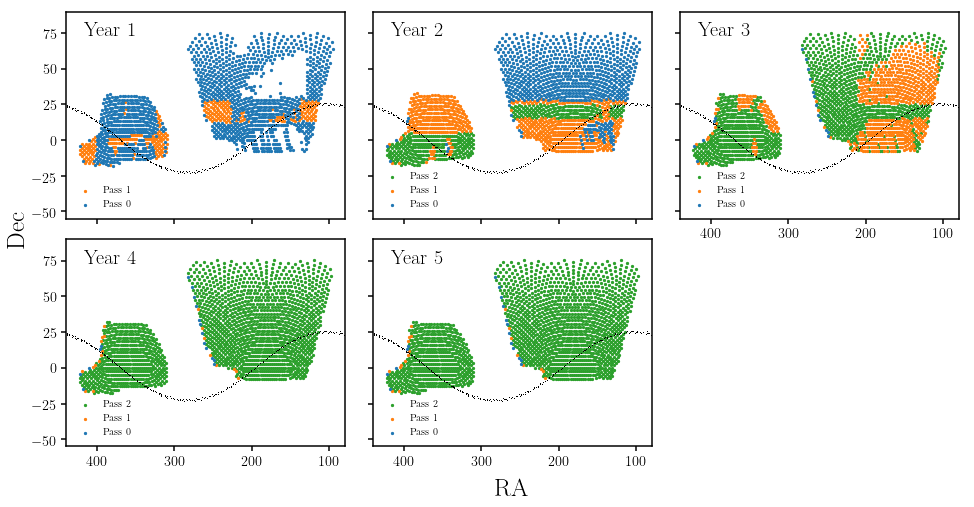

In [108]:
fig, exps, stats, moon_radec = surveysim_summary(300, 14000, version=8, deepfirst=False, twilight=False)
fig.savefig('figs/strategysim.pdf', bbox_inches='tight')

In [91]:
stats.tiles.tiles_file

'desi-tiles.fits'

In [82]:
stats.tiles.overlapping[6].shape

(1998, 1998)

In [84]:
np.count_nonzero(stats.tiles.tile_over[5])

0

In [85]:
np.count_nonzero(stats.tiles.tile_over[6])

1998

In [86]:
np.count_nonzero(stats.tiles.tile_over[7])

3996

In [25]:
stats.tiles.tileID

array([    4,     6,     7, ..., 46090, 46091, 46095], dtype=int32)

In [27]:
stats.tiles.passnum

array([0, 0, 0, ..., 7, 7, 7], dtype=int16)

In [28]:
stats.tiles.tileRA

array([334.81451466, 333.01036364, 332.14257944, ..., 244.69308567,
       247.11398399, 247.16251195])

In [29]:
stats.tiles.tileDEC

array([20.45422737, 15.41422737, 12.89422737, ...,  3.20363934,
        4.62363934,  1.69363934])

In [30]:
stats.tiles.pass_ntiles

{0: 1998, 1: 1998, 2: 1998, 3: 1998, 4: 1998, 5: 1998, 6: 1998, 7: 1998}

In [32]:
stats.tiles.program_passes

{'DARK': array([1, 2, 3, 4], dtype=int16),
 'GRAY': array([0], dtype=int16),
 'BRIGHT': array([5, 6, 7], dtype=int16)}

In [34]:
stats.tiles.pass_ntiles

{0: 1998, 1: 1998, 2: 1998, 3: 1998, 4: 1998, 5: 1998, 6: 1998, 7: 1998}

In [35]:
stats.tiles.pass_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

In [49]:
# get BGS tiles
_pass = np.zeros(len(stats.tiles.passnum)).astype(bool)

for i in range(3):
    _pass = _pass | (stats.tiles.passnum == stats.tiles.program_passes['BRIGHT'][i-3])

tileid_pass = stats.tiles.tileID[_pass]

In [55]:
len(_pass)

15984

In [61]:
np.all(np.isin(stats.tiles.passnum, stats.tiles.program_passes['BRIGHT']) == _pass)

True

In [62]:
    # ntile length array of whether in BGS. 
    _pass = np.isin(stats.tiles.passnum, stats.tiles.program_passes['BRIGHT'])

    # BGS tileids.
    tileid_pass = stats.tiles.tileID[_pass]
    
    _, m0, m1 = np.intersect1d(exps['TILEID'].data, tileid_pass, return_indices=True)

In [65]:
m0

array([ 8568,  7808,  7810, ..., 28726, 28732, 28736])

In [66]:
_

array([28814, 28816, 28817, ..., 46089, 46090, 46091], dtype=int32)

In [71]:
len(_), len(m0), len(m1)

(5592, 5592, 5592)

In [73]:
m0.dtype

dtype('int64')

In [133]:
    # Map to absolute pass number for third bright pass, e.g. returns pass 7. 
    third_pass = stats.tiles.program_passes['BRIGHT'][-1]
    
    # This is really ntile in the third pass. 
    npass = stats.tiles.pass_ntiles[third_pass]
    
    # Indices into pass array for non-consecutive / non-dense pass numbers.  
    passidx = stats.tiles.pass_index[third_pass]

In [134]:
stats.tiles.program_passes['BRIGHT']

array([5, 6, 7], dtype=int16)

# Done.